# Fraud Detection Analysis in Banking Transactions

This notebook focuses on analyzing transaction patterns, identifying anomalies, and developing fraud prevention strategies.

## Contents
1. [Data Loading and Preprocessing](#data-loading)
2. [Transaction Pattern Analysis](#transaction-patterns)
3. [Anomaly Detection](#anomaly-detection)
4. [Velocity Analysis](#velocity-analysis)
5. [Geographic Risk Analysis](#geographic-risk)
6. [Prevention Strategies](#prevention-strategies)

## Setup and Configuration

Import required libraries and set up configurations

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta

# Plotting configurations
#plt.style.use('seaborn')
%matplotlib inline

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Note: We will load and process the data directly in this notebook for now. In a production environment, we would use the custom utilities from the `src` directory for better code organization and reusability.

<a id='data-loading'></a>
## 1. Data Loading and Preprocessing

Load and prepare transaction data for analysis

In [5]:
# Load transaction data
transactions = pd.read_csv('C:/Users/GIDI/Desktop/Folders/REPOSITORY/FinRisk-ai/data/raw/transaction_data.csv')

# Convert datetime columns
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

# Display basic information
print("Transaction Data Shape:", transactions.shape)
print("\nSample Data:")
display(transactions.head())

Transaction Data Shape: (100000, 10)

Sample Data:


,transaction_id,customer_id,transaction_date,amount,merchant_category,transaction_type,location,device_info,fraud_flag,investigation_status
0,TXN_00000001,CUST_004019,2024-03-25 11:24:31,34.850,Groceries,Purchase,Manchester,Mobile,0,Not Investigated
1,TXN_00000002,CUST_000222,2022-05-24 14:21:01,84.320,Fuel,Purchase,Bristol,Mobile,0,Not Investigated
2,TXN_00000003,CUST_007895,2023-01-15 10:15:41,6.820,Fuel,Purchase,London,Chip,0,Not Investigated
3,TXN_00000004,CUST_021148,2023-10-03 06:15:45,59.900,Groceries,Purchase,Birmingham,Contactless,0,Not Investigated
4,TXN_00000005,CUST_016591,2024-11-24 09:09:02,71.010,Transfer,Transfer,Leeds,Desktop,0,Not Investigated


<a id='transaction-patterns'></a>
## 2. Transaction Pattern Analysis

Analyze patterns in transaction behavior

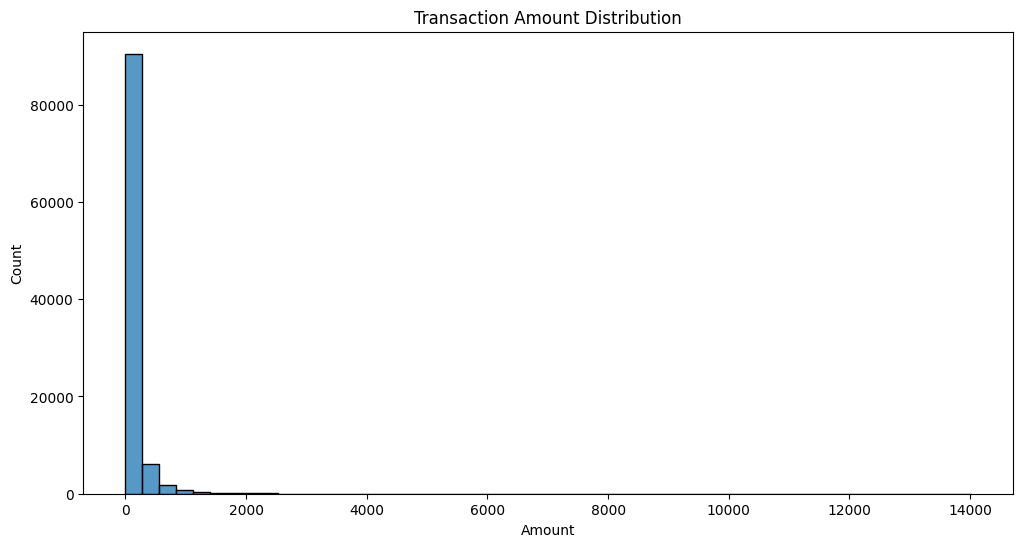

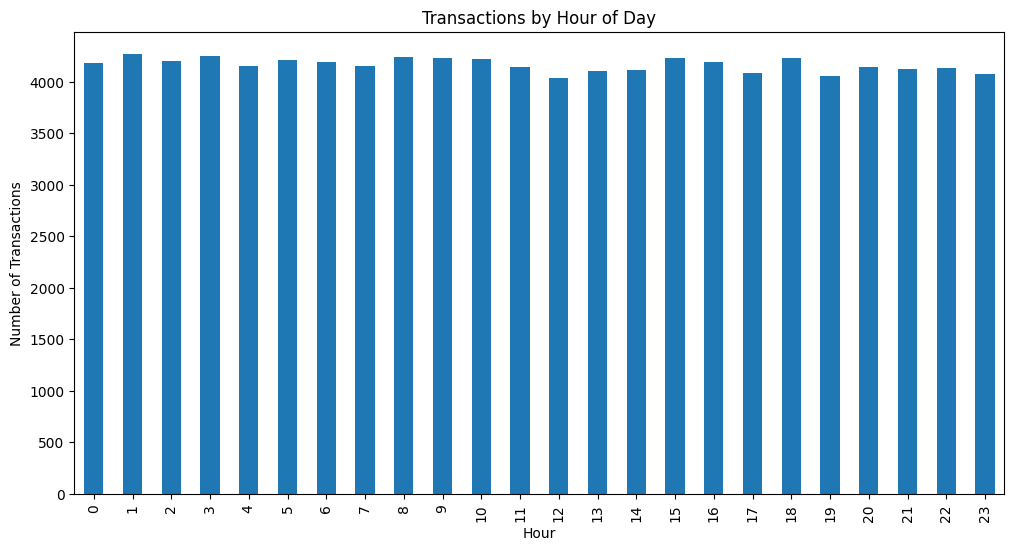

In [6]:
# Transaction amount distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=transactions, x='amount', bins=50)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.show()

# Transaction by hour of day
transactions['hour'] = transactions['transaction_date'].dt.hour
hourly_trans = transactions.groupby('hour').size()

plt.figure(figsize=(12, 6))
hourly_trans.plot(kind='bar')
plt.title('Transactions by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.show()

<a id='anomaly-detection'></a>
## 3. Anomaly Detection

Identify unusual transaction patterns

In [7]:
def detect_anomalies(data, threshold=3):
    # Calculate z-scores for amounts
    data['amount_zscore'] = np.abs((data['amount'] - data['amount'].mean()) / data['amount'].std())
    
    # Flag potential anomalies
    anomalies = data[data['amount_zscore'] > threshold]
    return anomalies

# Detect anomalies
anomalies = detect_anomalies(transactions)
print(f"Number of anomalous transactions: {len(anomalies)}")
display(anomalies.head())

Number of anomalous transactions: 1481


,transaction_id,customer_id,transaction_date,amount,merchant_category,transaction_type,location,device_info,fraud_flag,investigation_status,hour,amount_zscore
162,TXN_00000163,CUST_017195,2022-06-18 22:07:51,1061.410,Healthcare,Purchase,Birmingham,ATM,0,Not Investigated,22,3.771
268,TXN_00000269,CUST_020203,2023-03-20 07:53:35,2741.450,Utilities,Purchase,Newcastle,Chip,0,Not Investigated,7,10.466
270,TXN_00000271,CUST_007358,2022-10-16 05:03:47,1389.410,Healthcare,Purchase,Liverpool,Desktop,0,Not Investigated,5,5.078
509,TXN_00000510,CUST_016763,2023-01-08 04:50:27,1373.790,Restaurants,Purchase,Liverpool,Contactless,0,Not Investigated,4,5.016
549,TXN_00000550,CUST_013937,2022-06-05 11:41:29,1066.710,Fuel,Purchase,Cardiff,Chip,0,Not Investigated,11,3.792


<a id='velocity-analysis'></a>
## 4. Velocity Analysis

Analyze transaction velocity patterns

In [8]:
def analyze_velocity(data, time_window='1H'):
    # Calculate transaction frequency
    velocity = data.groupby(['customer_id', 
                           pd.Grouper(key='transaction_date', 
                                     freq=time_window)])['amount'].agg(['count', 'sum'])
    
    return velocity.reset_index()

# Analyze hourly velocity
velocity_stats = analyze_velocity(transactions)
print("Transaction Velocity Statistics:")
display(velocity_stats.describe())

C:\Users\GIDI\AppData\Local\Temp\ipykernel_21296\2739223894.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.Grouper(key='transaction_date',


Transaction Velocity Statistics:


,transaction_date,count,sum
count,99996,99996.000,99996.000
mean,2023-07-01 04:42:42.834513664,1.000,115.265
min,2022-01-01 00:00:00,1.000,1.000
25%,2022-09-29 22:00:00,1.000,16.460
50%,2023-06-30 21:00:00,1.000,45.370
75%,2024-03-31 05:00:00,1.000,118.050
max,2024-12-30 23:00:00,2.000,14011.650
std,NaN,0.006,250.937


<a id='geographic-risk'></a>
## 5. Geographic Risk Analysis

Analyze transaction risks by geography

In [15]:
# Analyze transactions by location
location_risk = transactions.groupby('location').agg({
    'transaction_id': 'count',
    'amount': ['mean', 'std'],
    'fraud_flag': 'mean'
}).round(3)

print("Geographic Risk Analysis:")
display(location_risk.sort_values(('fraud_flag', 'mean'), ascending=False).head())

Geographic Risk Analysis:


transaction_id  amount         fraud_flag
                    count    mean     std       mean
location                                            
Bristol             10113 126.097 304.282      0.002
Leeds                9832 111.845 219.821      0.002
Newcastle            9784 110.783 260.541      0.002
London              10013 114.053 234.192      0.002
Birmingham          10064 120.561 271.572      0.001

<a id='prevention-strategies'></a>
## 6. Prevention Strategies

Based on the analysis, here are key fraud prevention recommendations:

1. **Real-time Monitoring**
   - Implement velocity checks for rapid transactions
   - Set dynamic amount thresholds by customer segment
   - Monitor geographic dispersion of transactions
   - Track merchant category patterns

2. **Risk Scoring**
   - Develop composite risk scores incorporating:
     * Transaction amount anomalies
     * Velocity patterns
     * Geographic risk factors
     * Merchant category risk

3. **Customer Segmentation**
   - Create risk profiles based on:
     * Transaction history
     * Geographic patterns
     * Merchant preferences
     * Time-of-day patterns

4. **Operational Controls**
   - Implement stepped-up authentication for:
     * High-risk locations
     * Unusual amounts
     * Velocity breaches
     * New merchant categories

5. **Monitoring Framework**
   - Establish continuous monitoring of:
     * Pattern changes
     * New fraud types
     * Risk score effectiveness
     * False positive rates